## Model setup XBeach 2D

Setup a 2D XBeach model with the Python toolbox

In [115]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import os
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Import the toolbox and set the xbeach styleshoot for plotting

In [116]:
## import xbeach tools
sys.path.append(os.path.abspath(os.path.join('lib', 'xbeach-toolbox', 'scripts')))

from xbeachtools import xgrid, ygrid, seaward_extend, XBeachModelSetup, offshore_depth, lateral_extend
plt.style.use(os.path.join('lib', 'xbeach-toolbox', 'scripts', 'xb.mplstyle'))

### Data
Load and plot the bathymetry data

Text(0.5, 0.5, 'y [m]')

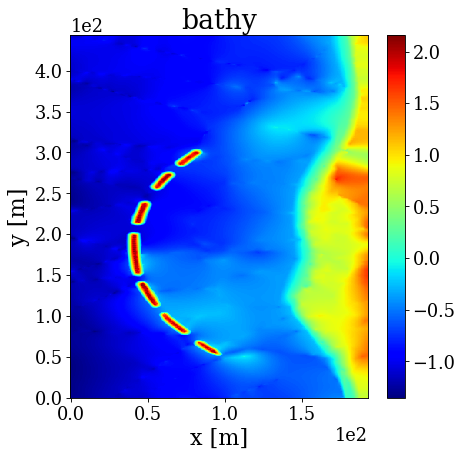

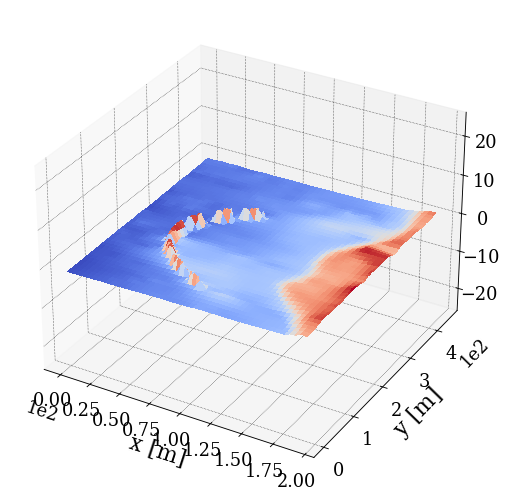

In [117]:
## load data
bathy = np.loadtxt('./lib/DEM-to-grid/output/bathy.dep')

## set bathy grid
nx = bathy.shape[1]
ny = bathy.shape[0]
dx = 0.5
dy = 0.5

x = np.linspace(0,(nx-1)*dx,nx)
y = np.linspace(0,(ny-1)*dy,ny)

X, Y = np.meshgrid(x,y)

## plot
plt.figure()
plt.pcolor(x,y,bathy)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('bathy')

fig = plt.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(-25, 25)
surf = ax.plot_surface(X, Y, bathy, cmap=cm.coolwarm,  linewidth=0, antialiased=False)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### Create x-grid
Create spatially varying x-grid resolution.

Text(0, 0.5, 'z [m]')

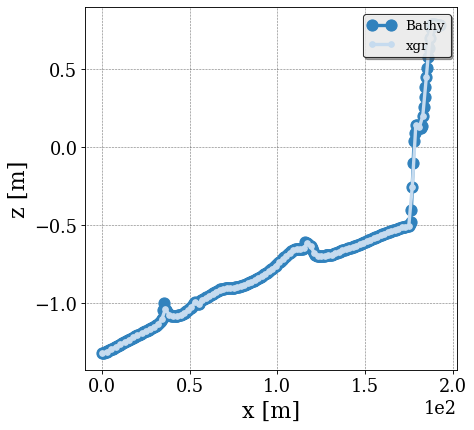

In [118]:
xgr,zgr = xgrid(x, bathy[20,:],dxmin=2)


plt.figure()
plt.plot(x,bathy[20,:],'-o')
plt.plot(xgr,zgr,'.-')
plt.legend(['Bathy','xgr'])
plt.xlabel('x [m]')
plt.ylabel('z [m]')

### Create y-grid

Create spatially varying y-grid resolution.

Enable optimization of transition distance
Area type center
Transition 44.300000000000004


/home/seth/projects/ssllc/northbay/lib/xbeach-toolbox/scripts/xbeachtools.py:471: RuntimeWarning: overflow encountered in double_scalars
  Lj[1] = cell1 * np.sum(np.power(fj[1],np.arange(1,ni+1,1)) )
/home/seth/projects/ssllc/northbay/lib/xbeach-toolbox/scripts/xbeachtools.py:471: RuntimeWarning: overflow encountered in power
  Lj[1] = cell1 * np.sum(np.power(fj[1],np.arange(1,ni+1,1)) )
/home/seth/projects/ssllc/northbay/lib/xbeach-toolbox/scripts/xbeachtools.py:472: RuntimeWarning: overflow encountered in double_scalars
  Lj[2] = cell1 * np.sum(np.power(np.mean(fj),np.arange(1,ni+1,1)) )
/home/seth/projects/ssllc/northbay/lib/xbeach-toolbox/scripts/xbeachtools.py:472: RuntimeWarning: overflow encountered in power
  Lj[2] = cell1 * np.sum(np.power(np.mean(fj),np.arange(1,ni+1,1)) )
/home/seth/projects/ssllc/northbay/lib/xbeach-toolbox/scripts/xbeachtools.py:462: RuntimeWarning: overflow encountered in double_scalars
  fj[1] = 1.1 * fj[1]


Transition 48.73000000000001
Transition 53.603000000000016
Transition 58.963300000000025
Transition 64.85963000000004
Transition 71.34559300000005
Transition 78.48015230000006
Transition 86.32816753000007
Transition 94.96098428300009


Text(0, 0.5, 'dy [m]')

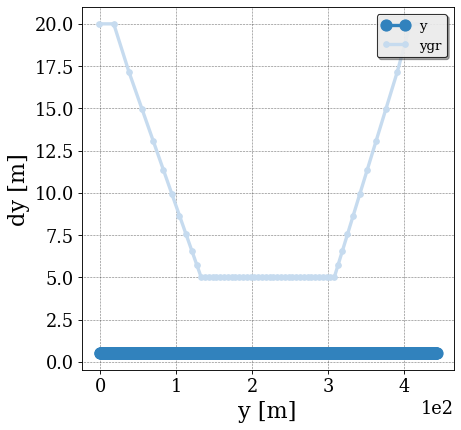

In [119]:
ygr = ygrid(y)

plt.figure()
plt.plot(y[:-1],np.diff(y),'-o')
plt.plot(ygr[:-1],np.diff(ygr),'.-')
plt.legend(['y','ygr'])
plt.xlabel('y [m]')
plt.ylabel('dy [m]')

### Interpolate
Interpolate data to new grid

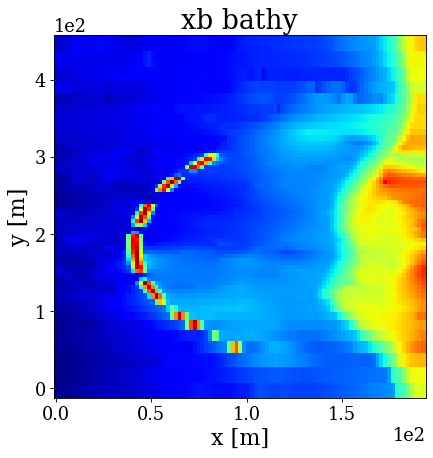

In [120]:
f = interpolate.interp2d(x, y, bathy, kind='linear')

zgr = f(xgr,ygr)

plt.figure()
plt.pcolor(xgr,ygr,zgr)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('xb bathy')

xgr, ygr = np.meshgrid(xgr,ygr)

### Seaward extend
Extend the grid to the required offshore depth. In this case 20 m with a artificial slope of 1/20.

Artificial slope of 1:10
Hm0,shoal = 5.721544477608835
d start = 19.110219776155322
Hm0,shoal/d profile = 4.413733247660724
Hm0,shoal/d slope = 0.2993971050373718
n profile = 0.501075514921838
n slope = 0.7522848806027095


Text(0, 0.5, 'z [m]')

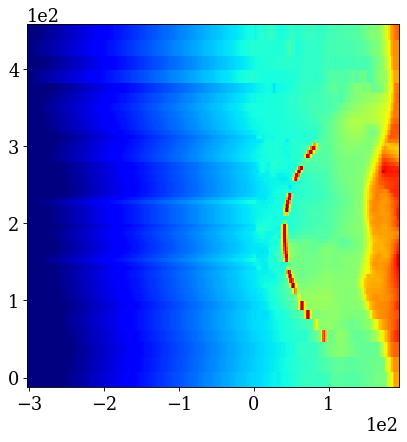

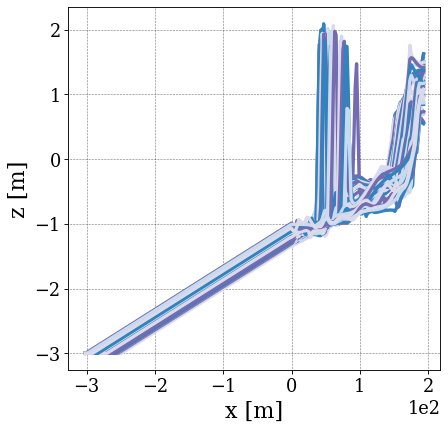

In [121]:
d_start, slope, Hm0_shoal = offshore_depth(Hm0=9, Tp=15, depth_offshore_profile=abs(bathy[0,0]), depth_boundary_conditions=10)

xgr, ygr, zgr = seaward_extend(xgr,ygr,zgr,slope=1/150,depth=-2)

plt.figure()
plt.pcolor(xgr,ygr,zgr)

plt.figure()
plt.plot(xgr[:,:].T,zgr[:,:].T)
plt.xlabel('x [m]')
plt.ylabel('z [m]')


### Lateral extend

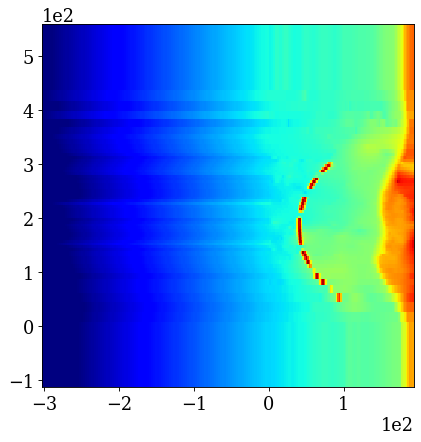

In [122]:
xgr,ygr,zgr = lateral_extend(xgr,ygr,zgr,n=5)

plt.figure()
plt.pcolor(xgr,ygr,zgr)

### Create model setup
Create the model setup class

In [123]:
xb_setup = XBeachModelSetup('Northbay')

print(xb_setup)

Northbay


Add the grid, wave boundary conditions and parameter to the model

In [124]:
xb_setup.set_grid(xgr,ygr,zgr)

xb_setup.set_waves('jonstable',{'Hm0':[1.5, 2, 1.5],'Tp':[4, 5, 4],'gammajsp':[3.3, 3.3, 3.3], 's' : [20,20,20], 'mainang':[270,280,290],'duration':[3600, 3600, 3600],'dtbc':[1,1,1]})

xb_setup.set_params({'Wavemodel':'surfbeat',
                     'morphology':0,
                     'befriccoef':0.01,
                     'tstop':3600,
                     'npointvar':['zb','zs','H'],
                     'nmeanvar':['zb'],
                     'npoints':['1 0', '6 0', '10 0', '12 0']})

Write the model setup

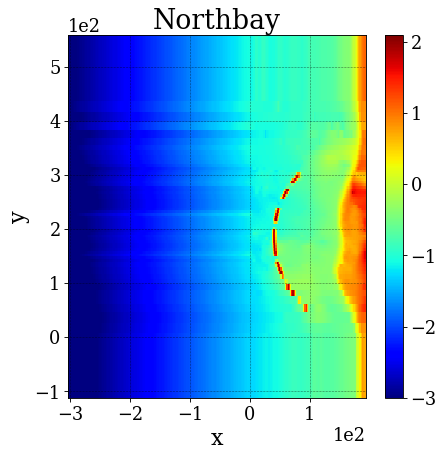

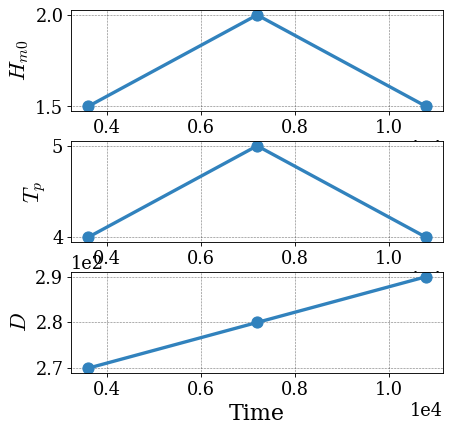

In [125]:
sim_path = os.path.join('output-2D')
if not os.path.exists(sim_path):
    os.mkdir(sim_path)
xb_setup.write_model(os.path.join(sim_path))